# Install detectron2

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
!pip install torch==1.8.1 torchvision==0.9.1 torchtext===0.9.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!find . -name ".DS_Store" -delete

     |████████████████████████████████| 274 kB 8.8 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=fd19f7227bd07bc73b0c71c069df02b4848c3dc466e01d08a154890dd62f56a5
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 804.1 MB 2.6 kB/s 
     |████████████████████████████████| 17.4 MB 119 kB/s 
     |████████████████████████████████| 7.1 MB 65.9 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully unins

In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 4.5 MB/s 
     |████████████████████████████████| 49 kB 3.7 MB/s 
     |████████████████████████████████| 144 kB 15.1 MB/s 
     |████████████████████████████████| 74 kB 4.3 MB/s 
     |████████████████████████████████| 130 kB 70.7 MB/s 
     |████████████████████████████████| 721 kB 53.7 MB/s 
     |████████████████████████████████| 743 kB 49.9 MB/s 
     |████████████████████████████████| 112 kB 72.8 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20210730-py3-none-any.whl size=60619 sha256=0a9d8b5b307b3c1b82f7b5ba273516b2c737c3c4c6cdfa40f3a5ad2653d75b55
  Stored in directory: /root/.cache/pip/wheels/fc/9c/12/9e9331cff3ddb5bb02a818886f0b52f5d160c54efa19d3516a
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141229 sha256=ee8e766e4040fb6a8b3e872f3b0e29850e2bf9ec54f5cd91f909bf1561b08d

In [3]:
# Basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Prepare the dataset


In [4]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [5]:
!rm -rf train 
!rm -rf validation 
!rm -rf test

In [6]:
# Unzip the training and test dataset quietly
!echo "Unzipping training set"
!unzip -q '/content/drive/MyDrive/Colab Notebooks/datasets/visdrone/train.zip' -d '/content'
!echo "Done!"

!echo "Unzipping validation set"
!unzip -q '/content/drive/MyDrive/Colab Notebooks/datasets/visdrone/validation.zip' -d '/content'
!echo "Done!"

!echo "Unzipping test set"
!unzip -q '/content/drive/MyDrive/Colab Notebooks/datasets/visdrone/test.zip' -d '/content'
!echo "Done!"

Unzipping training set
Done!
Unzipping validation set
Done!
Unzipping test set
Done!


In [7]:
from detectron2.data.datasets import register_coco_instances

#Register the training and test custom datasets (COCO format)
if 'visdrone_train' in DatasetCatalog.list():
  DatasetCatalog.remove("visdrone_train")
if 'visdrone_validation' in DatasetCatalog.list():
  DatasetCatalog.remove("visdrone_validation")
if 'visdrone_test' in DatasetCatalog.list():
  DatasetCatalog.remove("visdrone_test")

register_coco_instances("visdrone_train", {}, "/content/train/annotations.json", "/content/train/images")
register_coco_instances("visdrone_validation", {}, "/content/validation/annotations.json", "/content/validation/images")
register_coco_instances("visdrone_test", {}, "/content/test/annotations.json", "/content/test/images")

Verify that the training dataset loaded correctly. Visualise a few random images with their ground truths.


[08/02 05:53:21 d2.data.datasets.coco]: Loading /content/train/annotations.json takes 1.91 seconds.
[08/02 05:53:22 d2.data.datasets.coco]: Loaded 6471 images in COCO format from /content/train/annotations.json


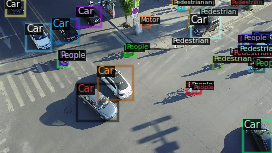

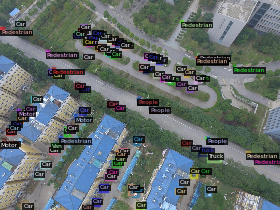

In [8]:
train_dataset_dicts = DatasetCatalog.get("visdrone_train")
train_metadata = MetadataCatalog.get("visdrone_train")

for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.2)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

Verify if validation dataset loads correctly. Visualise a few random images with their ground truths.


[08/02 05:53:27 d2.data.datasets.coco]: Loaded 548 images in COCO format from /content/validation/annotations.json


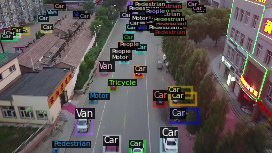

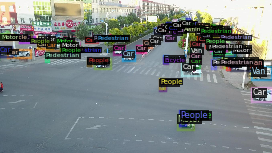

In [9]:
validation_dataset_dicts = DatasetCatalog.get("visdrone_validation")
validation_metadata = MetadataCatalog.get("visdrone_validation")

for d in random.sample(validation_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=validation_metadata, scale=0.2)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Training

Now, let's fine-tune a COCO-pretrained R50-C4 Faster R-CNN model on the training dataset.

In [ ]:
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultTrainer
import detectron2.utils.comm as comm

# Get default config for the specified model from Model Zoo, customize certain parameters
_config_file = "COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(_config_file))
cfg.DATASETS.TRAIN = ("visdrone_train",)
cfg.DATASETS.VAL = ("visdrone_validation",)
cfg.DATASETS.TEST = ("visdrone_validation",) 

# Add a custom hook to measure loss periodically on a validation dataset. 
class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        self._loader = iter(build_detection_train_loader(self.cfg))
        
    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)
            
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced, 
                                                 **loss_dict_reduced)

# Rest of the config
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(_config_file)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 12000
cfg.TEST.EVAL_PERIOD = 100
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 12


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
val_loss = ValidationLoss(cfg)  
trainer.register_hooks([val_loss])
# swap the order of PeriodicWriter and ValidationLoss
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
trainer.resume_or_load(resume=False)
trainer.train()

[08/02 05:53:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_298dad.pkl: 212MB [00:05, 36.7MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (13, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (13,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (48, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (48,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box

[08/02 05:53:53 d2.engine.train_loop]: Starting training from iteration 0
[08/02 05:54:16 d2.utils.events]:  eta: 2:40:16  iter: 19  total_loss: 3.656  loss_cls: 2.643  loss_box_reg: 0.6943  loss_rpn_cls: 0.1488  loss_rpn_loc: 0.1262  total_val_loss: 3.631  val_loss_cls: 2.637  val_loss_box_reg: 0.7093  val_loss_rpn_cls: 0.1003  val_loss_rpn_loc: 0.1655  time: 0.7779  data_time: 0.0314  lr: 4.9953e-06  max_mem: 3179M
[08/02 05:54:38 d2.utils.events]:  eta: 2:41:15  iter: 39  total_loss: 3.495  loss_cls: 2.56  loss_box_reg: 0.6715  loss_rpn_cls: 0.1351  loss_rpn_loc: 0.1601  total_val_loss: 3.552  val_loss_cls: 2.536  val_loss_box_reg: 0.7017  val_loss_rpn_cls: 0.08491  val_loss_rpn_loc: 0.1821  time: 0.7879  data_time: 0.0068  lr: 9.9902e-06  max_mem: 3179M
[08/02 05:55:01 d2.utils.events]:  eta: 2:42:26  iter: 59  total_loss: 3.284  loss_cls: 2.346  loss_box_reg: 0.6948  loss_rpn_cls: 0.13  loss_rpn_loc: 0.1473  total_val_loss: 3.345  val_loss_cls: 2.356  val_loss_box_reg: 0.6935  val

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
import json
import matplotlib.pyplot as plt

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr('/content/output/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics], 
    [x['total_loss'] for x in experiment_metrics])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_val_loss' in x], 
    [x['total_val_loss'] for x in experiment_metrics if 'total_val_loss' in x])
plt.legend(['total_loss', 'total_val_loss'], loc='upper left')
plt.show()

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


Then, we randomly select several samples to visualize the prediction results

In [ ]:
from detectron2.utils.visualizer import ColorMode

test_dataset_dicts = DatasetCatalog.get("visdrone_test")
test_metadata = MetadataCatalog.get("visdrone_test")

for d in random.sample(test_dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.5, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Evaluate its performance using AP metric implemented in COCO API.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("visdrone_test", ("bbox",), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "visdrone_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))